# Feature Selection

In [1]:
import pandas as pd
data = pd.read_csv('SPECTF_train.csv')
print(data.shape)
data.head(5)

(80, 45)


,DIAGNOSIS,F1R,F1S,F2R,F2S,F3R,F3S,F4R,F4S,F5R,...,F18R,F18S,F19R,F19S,F20R,F20S,F21R,F21S,F22R,F22S
0,1,59,52,70,67,73,66,72,61,58,...,66,56,62,56,72,62,74,74,64,67
1,1,72,62,69,67,78,82,74,65,69,...,65,71,63,60,69,73,67,71,56,58
2,1,71,62,70,64,67,64,79,65,70,...,73,70,66,65,64,55,61,41,51,46
3,1,69,71,70,78,61,63,67,65,59,...,61,61,66,65,72,73,68,68,59,63
4,1,70,66,61,66,61,58,69,69,72,...,67,69,70,66,70,64,60,55,49,41


In [166]:
train_acc = [] #list to store the accuracy values calculated on train data
test_acc = [] #list to store the accuracy values calculated on test data

In [3]:
y_train = data.pop('DIAGNOSIS').values
X_train = data.values

In [4]:
import pandas as pd
test = pd.read_csv('SPECTF_test.csv')
print(test.shape)
test.head(5)

(187, 45)


,DIAGNOSIS,F1R,F1S,F2R,F2S,F3R,F3S,F4R,F4S,F5R,...,F18R,F18S,F19R,F19S,F20R,F20S,F21R,F21S,F22R,F22S
0,1,67,68,73,78,65,63,67,60,63,...,61,56,76,75,74,77,76,74,59,68
1,1,75,74,71,71,62,58,70,64,71,...,66,62,68,69,69,66,64,58,57,52
2,1,83,64,66,67,67,74,74,72,64,...,67,64,69,63,68,54,65,64,43,42
3,1,72,66,65,65,64,61,71,78,73,...,69,68,68,63,71,72,65,63,58,60
4,1,62,60,69,61,63,63,70,68,70,...,66,66,58,56,72,73,71,64,49,42


In [5]:
y_test = test.pop('DIAGNOSIS').values
X_test = test.values

###### When I normalized the data using MinMax Scalar, the accuracy of the classifier on train data was 0.80 but it was less on test data i.e. 0.51  and without normalization the accuracy of the classifier on train and test data is 0.81 and 0.72. So, I am sticking with the unnormalised data.

### Gradient Boosting Classifier

In [6]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
gb = GradientBoostingClassifier(random_state=2)

### Cross Valisation on Training data using all features

In [167]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(gb, X_train, y_train, cv=6)
print("Accuracy on train set : {0:.2f}".format(scores.mean())) 
train_acc.append(scores.mean().round(2))


Accuracy on train set : 0.81


### Hold-out Testing on Test set using all features

In [168]:
from sklearn.metrics import accuracy_score
y_predt = gb.fit(X_train,y_train).predict(X_test)    
acc = accuracy_score(y_test, y_predt)
print("Accuracy on test set : {0:.2f}".format(acc))
test_acc.append(acc.round(2))

Accuracy on Test set : 0.72


##### Accuracy of classifier on all features

Training data: 0.81

Testing data: 0.72

### Feature Subset Selection using Information Gain as Filter

In [92]:
from sklearn.feature_selection import mutual_info_classif
mi = dict()

i_scores = mutual_info_classif(X_train, y_train)

for i,j in zip(data.columns,i_scores):
    mi[i]=j
 
df = pd.DataFrame.from_dict(mi,orient='index',columns=['I-Gain'])
df.sort_values(by=['I-Gain'],ascending=False,inplace=True)
df.head(5)

,I-Gain
F15S,0.206959
F13R,0.179287
F13S,0.168439
F20S,0.159700
F6S,0.144336


### I-Gain vs Features Plot

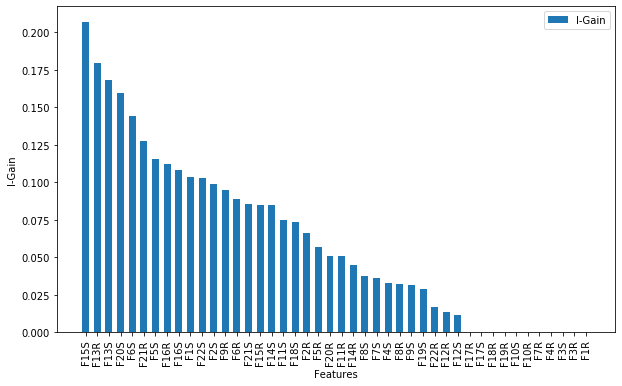

In [162]:
import matplotlib.pyplot as plt
%matplotlib inline

n = len(df.index)
rr = range(1,n)
fig, ax = plt.subplots(figsize=(10,6))
ax.bar(df.index, df["I-Gain"], label='I-Gain',width=0.6)
ax.set_xticklabels(list(df.index), rotation = 90)
ax.set_xlabel('Features')
ax.set_ylabel('I-Gain')

ax.legend()

plt.show()

### Selecting the k best features by applying cross validation on training data
We rank the features using information gain (well mutual information) and select the _k_ best to build a classifier.  
We iterate through increasing values of *k*.  

In [94]:
from sklearn.feature_selection import SelectKBest
acc_scores = []
for kk in range(1, X_train.shape[1]+1):
    FS_trans = SelectKBest(mutual_info_classif,k=kk).fit(X_train, y_train)
    X_tR_new = FS_trans.transform(X_train)

    from sklearn.model_selection import cross_val_score
    scores = cross_val_score(gb, X_tR_new, y_train, cv=6)
    acc_scores.append(scores.mean())

df['Accuracy'] = acc_scores
df.head(5)



,I-Gain,Accuracy
F15S,0.206959,0.738095
F13R,0.179287,0.674603
F13S,0.168439,0.736111
F20S,0.159700,0.736111
F6S,0.144336,0.777778


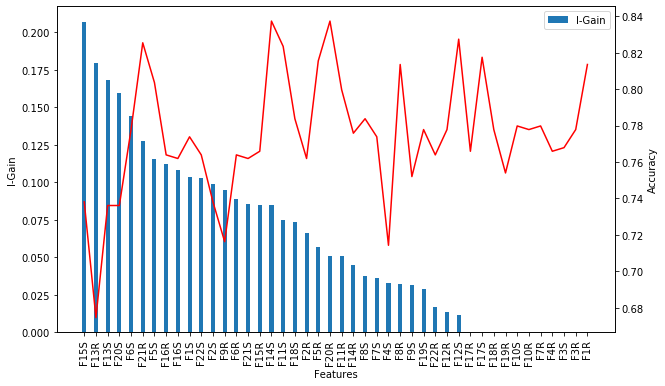

In [95]:
import matplotlib.pyplot as plt
%matplotlib inline

n = len(df.index)
rr = range(1,n)
fig, ax = plt.subplots(figsize=(10,6))
ax2 = ax.twinx()
ax.bar(df.index, df["I-Gain"], label='I-Gain',width=.35)
ax2.plot(df.index, df["Accuracy"], color='red', label='Accuracy')
ax.set_xticklabels(list(df.index), rotation = 90)
ax.set_xlabel('Features')
ax.set_ylabel('I-Gain')
ax2.set_ylabel('Accuracy')
ax.legend()

plt.show()

### Different Peaks

###### Different Accuracy peaks on every run

*Run 1*: Peak1 at F17R with number of features : 18

*Run 2*: Peak2 at F15R with number of features: 21

*Run 3*: Peak3 at F16S with number of features: 14

*Run 4*: Peak4 at F14R with number of features : 22

*Run 5*: Peak5 at F14S with number of features: 17


Thus, took the mean of all the features for different peaks which came out to be 18 features, thus took subset of 18 features as top *k* features for I-Gain.



In [124]:
for kk in range(1, X_train.shape[1]+1):
    FS_trans = SelectKBest(mutual_info_classif,k=18).fit(X_train, y_train)
    X_train_fs = FS_trans.transform(X_train)
    X_test_fs = FS_trans.transform(X_test)

### Cross Validation for accuracy of the classifier on Training data using selected subset of features

In [169]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(gb, X_train_fs, y_train, cv=6)
print("Accuracy on Train Set : {0:.2f}".format(scores.mean())) 
train_acc.append(scores.mean().round(2))

Accuracy on Train Set : 0.80


### Hold-Out Testing for accuracy of the classifier on Testing data using selected subset of features 


In [170]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


gbh= gb.fit(X_train_fs, y_train)
y_predh = gbh.predict(X_test_fs)
    
acc = accuracy_score(y_test, y_predh)
print("Accuracy on Test set : {0:.2f}".format(acc))
test_acc.append(acc.round(2))

Accuracy on Test set : 0.74


#### Accuracy on Training and Testing Data with 18 selected features

Training Data = 0.80

Testing Data = 0.74

#### Obseravation
The accuracy of the classifier on train data after feature subset selection decreased from 0.81 to 0.80 whereas for test data the accuracy was 0.74 which was higher than the value of accuracy with all features i.e. 0.72. The features got reduced from 44 to 18.

I-Gain is an unstable method for selecting the subset of features as accuracy for features is changing every time we try to select top K features.

I-Gain doesn't take into account the correlation between features.

### Wrapper-based forward sequential search for feature selection



In [137]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
names = data.columns
print(names)
sfs_forward = SFS(gb, 
                  k_features=44, 
                  forward=True, 
                  floating=False, 
                  verbose=1,
                  scoring='accuracy',
                  cv=10, n_jobs = -1)

sfs_forward = sfs_forward.fit(X_train, y_train, 
                              custom_feature_names=names)

Index(['F1R', 'F1S', 'F2R', 'F2S', 'F3R', 'F3S', 'F4R', 'F4S', 'F5R', 'F5S',
       'F6R', 'F6S', 'F7R', 'F7S', 'F8R', 'F8S', 'F9R', 'F9S', 'F10R', 'F10S',
       'F11R', 'F11S', 'F12R', 'F12S', 'F13R', 'F13S', 'F14R', 'F14S', 'F15R',
       'F15S', 'F16R', 'F16S', 'F17R', 'F17S', 'F18R', 'F18S', 'F19R', 'F19S',
       'F20R', 'F20S', 'F21R', 'F21S', 'F22R', 'F22S'],
      dtype='object')


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  44 out of  44 | elapsed:    6.8s finished
Features: 1/44[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  43 out of  43 | elapsed:    7.7s finished
Features: 2/44[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 out of  42 | elapsed:    8.1s finished
Features: 3/44[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  41 out of  41 | elapsed:    7.3s finished
Features: 4/44[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    6.4s finished
Features: 5/44[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  39 out of  39 | elapsed:    6.4s finished
Features: 6/44[Parallel(n_jobs=-1)]: Using backe

### Plot of Accuracy vs Number of Features

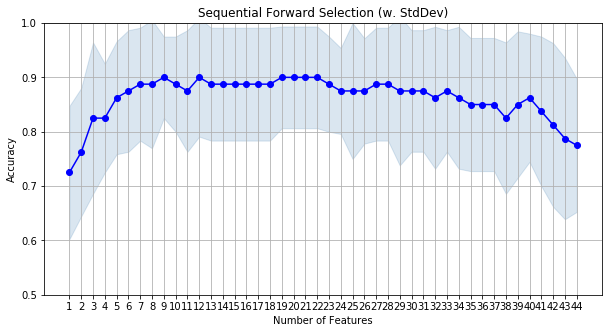

('F1R', 'F1S', 'F2R', 'F2S', 'F3R', 'F3S', 'F4R', 'F4S', 'F5R', 'F5S', 'F6R', 'F6S', 'F7R', 'F7S', 'F8R', 'F8S', 'F9R', 'F9S', 'F10R', 'F10S', 'F11R', 'F11S', 'F12R', 'F12S', 'F13R', 'F13S', 'F14R', 'F14S', 'F15R', 'F15S', 'F16R', 'F16S', 'F17R', 'F17S', 'F18R', 'F18S', 'F19R', 'F19S', 'F20R', 'F20S', 'F21R', 'F21S', 'F22R', 'F22S')


In [138]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
import matplotlib.pyplot as plt

fig1 = plot_sfs(sfs_forward.get_metric_dict(), 
                ylabel='Accuracy',
                kind='std_dev',figsize=(10,5))

plt.ylim([0.5, 1])
plt.title('Sequential Forward Selection (w. StdDev)')
plt.grid()
plt.show()

print(sfs_forward.k_feature_names_)

Ran sequential forward search for 44 features to select the best features subset from the Accuracy vs Number of Features graph. From graph we can see that the maximum peak of accuracy is at 9th feature. After 9th feature the accuracy is continously decreasing and flattening but it is not higher than 9th feature at any other feature.

**Ran sequential forward search with top 9 features selected above.**

In [139]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
names = data.columns

sfs_forward = SFS(gb, 
                  k_features=9, 
                  forward=True, 
                  floating=False, 
                  verbose=1,
                  scoring='accuracy',
                  cv=10, n_jobs = -1)

sfs_forward = sfs_forward.fit(X_train, y_train, 
                              custom_feature_names=names)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  44 out of  44 | elapsed:    5.7s finished
Features: 1/9[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  43 out of  43 | elapsed:    6.5s finished
Features: 2/9[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 out of  42 | elapsed:    6.5s finished
Features: 3/9[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  41 out of  41 | elapsed:    6.6s finished
Features: 4/9[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    7.1s finished
Features: 5/9[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  39 out of  39 | elapsed:    6.4s finished
Features: 6/9[Parallel(n_jobs=-1)]: Using backend Lok

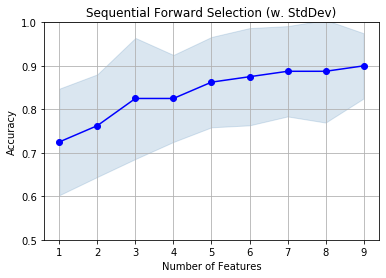

('F2S', 'F3R', 'F5R', 'F7R', 'F9R', 'F16R', 'F16S', 'F20S', 'F21R')


In [140]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
import matplotlib.pyplot as plt

fig1 = plot_sfs(sfs_forward.get_metric_dict(), 
                ylabel='Accuracy',
                kind='std_dev')

plt.ylim([0.5, 1])
plt.title('Sequential Forward Selection (w. StdDev)')
plt.grid()
plt.show()

print(sfs_forward.k_feature_names_)

X_train_f = sfs_forward.transform(X_train)
X_test_f  = sfs_forward.transform(X_test)


### Cross Validation for accuracy of the classifier on Training data using selected subset of features

In [171]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(gb, X_train_f, y_train, cv=6)
print("Accuracy on train set : {0:.2f}".format(scores.mean())) 
train_acc.append(scores.mean().round(2))

Accuracy on train set : 0.83


### Hold-Out Testing for accuracy of the classifier on Testing data using selected subset of features  



In [172]:
from sklearn.metrics import accuracy_score
gbh1= gb.fit(X_train_f, y_train)
y_predh1 = gbh1.predict(X_test_f)
    
acc = accuracy_score(y_test, y_predh1)
print("Accuracy on test set : {0:.2f}".format(acc))
test_acc.append(acc.round(2))

Accuracy on test set : 0.75


#### Accuracy on Training and Testing Data with 9 features selected 

Training Data: 0.83

Testing Data: 0.75

#### Observation
The accuracy of the classifier on train data after feature subset selection is higher than the value of accuracy with all features. It increased from 0.81 to 0.83 and also for test data it increased from 0.72 to 0.75. The features got reduced from 44 to 9 which is a very good outcome from Wrapper Forward as with very less number of features we are getting good accuracy.

This method of feature selection is stable as we are getting similar peak, subset of features and accuracy on every run.

### Wrapper-based backward elimination search for feature selection

In [145]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
names = data.columns
bfs_backward = SFS(gb, k_features=1,forward=False,floating=False,verbose=1,scoring='accuracy', cv=10, n_jobs=-1)

bfs_backward = bfs_backward.fit(X_train, y_train, custom_feature_names=names)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  44 out of  44 | elapsed:    9.6s finished
Features: 43/1[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  43 out of  43 | elapsed:   11.7s finished
Features: 42/1[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 out of  42 | elapsed:   10.0s finished
Features: 41/1[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  41 out of  41 | elapsed:    9.6s finished
Features: 40/1[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   10.0s finished
Features: 39/1[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  39 out of  39 | elapsed:    8.3s finished
Features: 38/1[Parallel(n_jobs=-1)]: Using backe

### Plot of Accuracy vs Number of Features

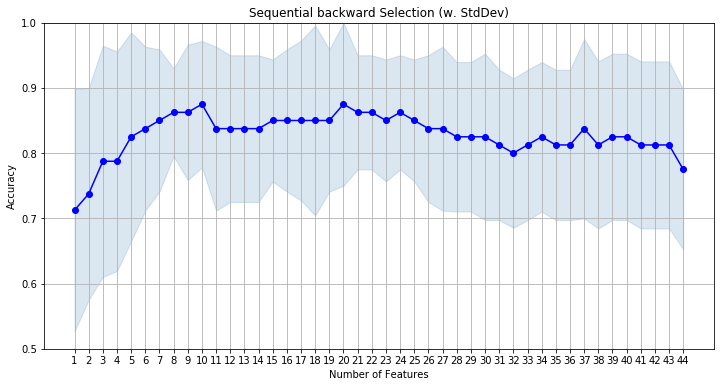

('F15S',)


In [146]:
select =[]
best_features =[]
import matplotlib.pyplot as plt

fig1 = plot_sfs(bfs_backward.get_metric_dict(), 
                ylabel='Accuracy',
                kind='std_dev',figsize=(12,6))

plt.ylim([0.5, 1])
plt.title('Sequential backward Selection (w. StdDev)')
plt.grid()
plt.show()
print(bfs_backward.k_feature_names_)


    
X_train_b = bfs_backward.transform(X_train)
X_test_b   = bfs_backward.transform(X_test)

From the graph, we can see that from feature number 28 the accuracy began to increase and as we move further in the backward direction we can see that the peak is maximum at 20. Thus, we take 9 features from feature 28 until feature 20 in the reduced feature set.

### Cross Validation for accuracy of the classifier on Training data using selected subset of features


In [173]:
best_features = ['F10S','F11R','F11S','F12R','F12S','F13R','F13S','F14R','F14S']
X_train_b = data[best_features]
X_test_b = test[best_features]

from sklearn.model_selection import cross_val_score
scores = cross_val_score(gb, X_train_b, y_train, cv=6)
print("Accuracy on train set : {0:.2f}".format(scores.mean())) 
train_acc.append(scores.mean().round(2))

Accuracy on train set : 0.68


### Hold-Out Testing for accuracy of the classifier on Testing data using selected subset of features  

In [174]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

gbh2= gb.fit(X_train_b, y_train)
y_predh2 = gbh2.predict(X_test_b)
    
acc = accuracy_score(y_test, y_predh2)
print("Accuracy on Test set : {0:.2f}".format(acc))
test_acc.append(acc.round(2))

Accuracy on Test set : 0.65


#### Accuracy on Training and Testing Data with 9 selected features

Training Data: 0.68

Testing Data: 0.65

#### Observation
The accuracy of the classifier on train data after feature subset selection reduced from 0.81 to 0.68 and it also got reduced for test data from 0.72 to 0.65. 

This method of feature selection is not an efficient method of feature selection in terms of accuracy. But this is stable as we are getting similar subset of features and accuracy on every run.

### Accuracy vs Feature selection approach

In [175]:
print(train_acc)
print(test_acc)

[0.81, 0.8, 0.83, 0.68]
[0.72, 0.74, 0.75, 0.65]


### Summary Plot of Training and Testing Accuracy

From the bar chart, we can see that the accuracy of train and test set is least in case of Wrapper-Backward Elimination Search. For I-Gain and Wrapper-Forward Sequential Search the train and test accuracy value is higher than the accuracy value using all features. But, the train and test accuracy for Wrapper-Forward Sequential is higher than the I-Gain. Also, I-Gain is not a stable method. Thus, we can conclude that Wrapper-Forward Sequential Search is the most stable and suitable method for finding the least number of features subset with good accuracy of train and test set amongst all.


Text(0, 0.5, 'Accuracy')

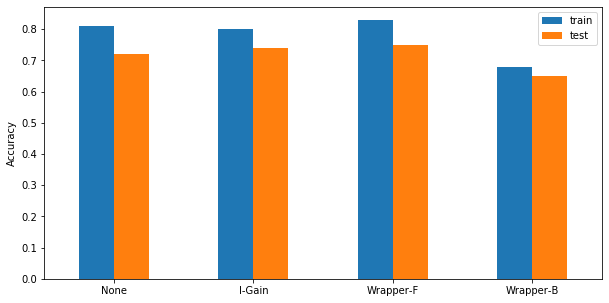

In [176]:
index = ['None','I-Gain','Wrapper-F','Wrapper-B']
df_plot = pd.DataFrame({'train': train_acc,
                    'test': test_acc}, index=index)

ax = df_plot.plot.bar(rot=0,figsize=(10,5))
ax.set_ylabel("Accuracy")

## Insight

We can observe from the above results that there are various feature subsets for which we have similar accuracy, as we are getting different subsets for every feature selection method. This is due to that fact that there are **many local minimas in the datset with no global minima**. 

If it would have been a larger dataset then we could have found a single particular feature subset with a good accuracy on train and test set as there are less chances of local minimas and high chance of global minima.